In [1]:
%matplotlib inline


# Label image regions


This example shows how to segment an image with image labelling. The following
steps are applied:

1. Thresholding with automatic Otsu method
2. Close small holes with binary closing
3. Remove artifacts touching image border
4. Measure image regions to filter small objects



In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import glob
import random
import cv2
from skimage.measure import label as measure_label
from skimage.measure import regionprops as measure_regionprops
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.io import savemat, loadmat

import assets.utils as u

In [3]:
labels_all = u.load_labels('C:/Users/ustundag/Github/2D-3D-Semantics/assets/semantic_labels.json')

# Function to map int labels to object classes
def assign_label(object):
    switcher = {
        'board':    0,
        'bookcase': 1,
        'chair':    2,
        'door':     3,
        'sofa':     4,
        'table':    5,
        'window':   6,
        '<UNK>':    7,
        'wall':     8,
        'beam':     9,
        'ceiling':  10,
        'clutter':  11,
        'column':   12,
        'floor':    13
    }
    return switcher.get(object, 14)

def convert_pixel_to_label(pixel):
    limit = int(len(labels_all))
    i = u.get_index(pixel)
    if i < limit:
        instance_label = labels_all[i]
        instance_label_as_dict = u.parse_label(instance_label)
        label = assign_label(instance_label_as_dict["instance_class"])
        return int(label)
    
    return 14 # default as missing data in case index is out of bounds in "labels.json" file

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def sharpen(img_arr):
    #img_arr = img_arr.reshape(299, 299, 3)
    kernel = np.array([[-1,-1,-1,-1,-1],
                       [-1, 2, 2, 2,-1],
                       [-1, 2, 8, 2,-1],
                       [-2, 2, 2, 2,-1],
                       [-1,-1,-1,-1,-1]])/8.0
    return cv2.filter2D(img_arr, -1, kernel)

img_rgb.shape:  (2048, 4096, 4)
img_sem.shape:  (2048, 4096, 3)


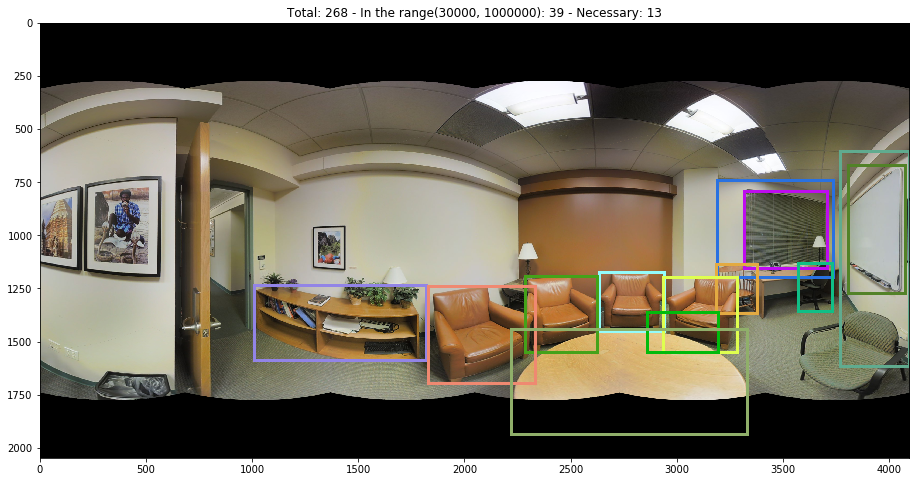

In [4]:
input_size = (299, 299)
crops = []
path = "C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\area_3\\data\\rgb\\camera*.png"
i = 1
for file in glob.glob(path):
    file = "C:\\Users\\ustundag\\Desktop\\camera_04a287849657478ea774727e5bff5202_office_3_frame_equirectangular_domain_rgb.png"
    # Read RGB and Semantic images
    img_rgb  = Image.open(file)
    print("img_rgb.shape: ", np.array(img_rgb).shape)
    file     = file.replace("rgb", "semantic", 2) # find counterpart of RGB image as Semantic and replace 2 occurrences
    img_sem  = np.asarray(Image.open(file))
    print("img_sem.shape: ", img_sem.shape)
    semantic = rgb2gray(img_sem)
    semantic = semantic.astype('uint8') # Change datatype from float to int
    semantic = measure_label(semantic) # create labeled mask

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(img_rgb)

    # Bounding box = (min_row, min_col, max_row, max_col)
    area_threshold = range(30000, 1000000)
    region_props = measure_regionprops(semantic)
    region_props_pruned = list(filter(lambda region: region.bbox_area in area_threshold, region_props))

    color = ["#"+''.join([random.choice('0123456789ABCDEF') for k in range(6)])
             for m in range(len(region_props_pruned))]
    c = 0
    m = 0 # counter for necessary regions
    for region in region_props_pruned:
        minr, minc, maxr, maxc = region.bbox
        # Find center_x, center_y of the region
        center_x, center_y = round((minr+maxr)/2), round((minc+maxc)/2)
        pixel = img_sem[center_x, center_y]
        label = convert_pixel_to_label(pixel)
        # unnecessary objects after label=6 like <UNK>, beam, ceiling, clutter, column, floor, wall.
        # see assign_label() function.
        if label < 7:
            rect = patch.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor=color[c], linewidth=3)
            ax.add_patch(rect)
            croped = img_rgb.crop((minc, minr, maxc, maxr))
            croped = np.array(croped.resize(input_size, Image.NEAREST))/255.0
            croped = sharpen(croped)
            crops.append(croped)
                
            c += 1
            m += 1
            
    plt.title('Total: '+str(len(region_props)) +' - '+
              'In the '+str(area_threshold)+': '+str(len(region_props_pruned)) +' - '+
              'Necessary: '+str(m))
    plt.show()

    i += 1 # holds image index
    if i > 1: break

In [5]:
def save_regions():
    path = "C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\area_3\\data\\rgb\\camera*.png"
    input_size = (299, 299)
    batch_size = 1000
    batch = 0
    i = 0 # holds image index
    b = 0 # holds batch index
    regions = []
    labels  = []
    for file in glob.glob(path):
        clear_output(wait=True)
        # Read RGB and Semantic images
        img_rgb  = Image.open(file)
        file     = file.replace("rgb", "semantic", 2) # find counterpart of RGB image as Semantic and replace 2 occurrences
        img_sem  = np.asarray(Image.open(file))
        semantic = rgb2gray(img_sem)
        semantic = semantic.astype('uint8') # Change datatype from float to int
        semantic = measure_label(semantic) # create labeled mask
    
        area_threshold = range(10000, 1000000)
        region_props = measure_regionprops(semantic)
        # Prune the regions of which area is above the threshold
        region_props_pruned = list(filter(lambda region: region.bbox_area in area_threshold, region_props))

        j = 0 # holds region box index
        for region in region_props_pruned:
            # Bounding box = (min_row, min_col, max_row, max_col)
            minr, minc, maxr, maxc = region.bbox
            # Find center_x, center_y of the region
            center_x, center_y = round((minr+maxr)/2), round((minc+maxc)/2)
            pixel = img_sem[center_x, center_y]
            label = convert_pixel_to_label(pixel)
            filename = 'image'+'_'+str(i)+'_'+'region'+'_'+str(j)+'_'+'label'+'_'+str(label)
            # unnecessary objects after label=6 like <UNK>, beam, ceiling, clutter, column, floor, wall.
            # see assign_label() function.
            #if label < 7:
            if label == 2: # find only chairs
                # Pillow crop parameters =(left, upper, right, lower)
                croped = img_rgb.crop((minc, minr, maxc, maxr))
                croped = np.array(croped.resize(input_size, Image.NEAREST))/255.0
                croped = sharpen(croped)
                regions.append(croped.flatten())
                labels.append(label)
            j += 1
        
        # len(regions) = 14661; Causing memory error! So split them into batches.
        if len(regions) > batch_size:
            file = 'noXYZ_area_3_no_xyz_data_ChairRegions_299x299_BatchSize_{}_BatchNo_{}.mat'.format(str(batch_size), str(b))
            savemat(file, {'regions': np.array(regions)})
            regions = []
            labels  = []
            b += 1
        
        i += 1
        display(str(i) + " / 3704")
    
    file = 'noXYZ_area_3_no_xyz_data_ChairRegions_299x299_BatchSize_{}_BatchNo_{}.mat'.format(str(len(regions)), str(b))
    savemat(file, {'regions': np.array(regions)})

In [6]:
#save_regions()

In [7]:
"""
objects = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\noXYZ_area_3_no_xyz_data_semantic_regions_chairs_299x299.mat")
objects = objects["regions"]
labels  = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\noXYZ_area_3_no_xyz_data_semantic_regions_chairs_299x299_labels.mat")
labels  = labels["labels"]
"""

'\nobjects = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\noXYZ_area_3_no_xyz_data_semantic_regions_chairs_299x299.mat")\nobjects = objects["regions"]\nlabels  = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\noXYZ_area_3_no_xyz_data_semantic_regions_chairs_299x299_labels.mat")\nlabels  = labels["labels"]\n'

In [8]:
"""
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(objects[0:i].reshape(299, 299, 3))
plt.show()
"""

'\nplt.figure(figsize=(8, 8))\nfor i in range(4):\n    plt.subplot(1, 4, i + 1)\n    plt.imshow(objects[0:i].reshape(299, 299, 3))\nplt.show()\n'

In [9]:
len(regions)

NameError: name 'regions' is not defined